## 11.模型优化与部署

**学习目标**

1. 了解模型剪枝的原理和Torch-Pruning结构化剪枝框架

2. 会使用Torch-Pruning对常见的模型进行结构化剪枝

3. 了解模型量化的原理和常用的模型量化工具

4. 熟悉模型量化的基本流程，能够对常见模型进行量化

5. 能够将PyTorch模型转化为ONNX模型

6. 了解模型在工业现场的部署方式

***

### 11.1 模型优化与部署概述

模型优化与部署是人工智能模型应用的两个重要环节。模型优化是指通过各种技术手段改善模型的性能、效率和可部署性的过程，模型部署是指将训练好的模型部署到实际生产环境中，让模型在实际应用中发挥作用。

1. 模型优化

模型优化是指通过各种技术手段改善模型的性能、效率和可部署性的过程。模型优化的目标是在不牺牲太多模型性能的前提下，使模型更适合实际应用的需求。这通常包括以下几个方面：

- 通过减少模型的计算复杂度，提高模型在推理时的速度，使其能够更快地响应请求。

- 通过剪枝、量化、权重共享等技术减少模型的存储大小，便于模型的传输和存储。

- 使模型能够在不同的硬件和软件平台上运行，如CPU、GPU、TPU、移动设备等。

- 根据模型部署的目标环境（如云端、边缘设备、嵌入式系统等），进行特定的优化。

模型优化的技术包括：模型剪枝、模型量化、模型蒸馏、混合精度训练等。

2. 模型部署

在生产环境中部署模型，主要涉及以下几个关键步骤：

（1）模型转换

首先需要将训练好的模型转换为适合部署的格式。例如，PyTorch模型可以通过TorchScript或ONNX转换，而TensorFlow模型可以直接使用SavedModel格式或转换为TensorFlow Lite。转换后，模型可能需要进行量化等，以提高推理速度和减少模型大小。

（2）模型服务部署

模型转换完成后，需要将其部署为提供预测服务的形式。这通常涉及到使用Web框架（如Flask、Django）构建API服务，或者使用专门的模型推理框架（如TorchServe、TensorFlow Serving）。在一些情况下，可能会使用容器化技术（如Docker）和编排工具（如Kubernetes）来实现大规模分布式部署。

（3）性能优化

部署后，还需要对模型服务进行性能优化，包括硬件加速（利用GPU、TPU等）、批处理、缓存优化和分布式部署等。

（4）监控与运维

建立监控系统来跟踪模型服务的性能指标，使用日志分析系统来及时发现和定位问题，并确保模型服务的高可用性。

（5）安全性保护

在部署过程中，需要考虑数据和模型的安全性，包括使用HTTPS、身份验证和权限管理等措施。

（6）A/B测试

在实际部署中，可能会使用A/B测试来评估新模型的效果，并确保平稳过渡。

在具体技术选型上，可能会使用TensorRT、LibTorch、OpenVINO等工具来加速模型的推理。例如，TensorRT是NVIDIA提供的一个用于深度学习推理优化的工具，它可以显著提升GPU上的推理性能 。

此外，还有一些开源项目和平台，如BentoML、ModelOps等，提供了模型全生命周期管理的工具，帮助企业更高效地进行模型的研发、部署和管理 。

在部署过程中，还需要考虑模型的版本控制、API流水线、监控分析等，以确保模型的持续迭代和优化。

总的来说，深度学习模型的优化和部署是一个涉及多个方面的复杂工程问题，需要根据具体的业务需求、性能要求和基础设施情况来选择合适的部署方案。

本章主要展示在NVIDIA GPU上部署PyTorch模型的简单流程：模型剪枝 --> 模型转换 --> 模型量化 --> 模型部署 。

### 11.2 模型剪枝

模型剪枝和量化是两种重要的模型优化技术，它们对于大模型和边缘设备的部署尤为关键。对大模型而言，模型复杂度和参数量急剧增加，这给模型的训练和部署带来了巨大挑战。而边缘设备通常具有有限的计算能力和内存，并且需要在低功耗下运行。此外，模型剪枝和量化还可以提高模型的部署效率和响应速度，降低模型的总体拥有成本，并且在数据隐私和安全性方面提供优势，因为数据可以在当地处理而不需要发送到云端。

1. **什么是模型剪枝？**

模型剪枝（Model Pruning）是一种模型压缩技术，它通过移除神经网络中的一些权重或神经元来减少模型的复杂度和大小。这样做的目的是为了提高模型的推理速度，降低模型对计算资源的需求，同时尽量保持模型的性能（如准确率）。模型剪枝通常在模型训练完成后进行。

模型剪枝可以分为两大类：

非结构化剪枝（Unstructured Pruning）：
   - 在这种剪枝中，网络中的单个权重被设置为零（即被“剪掉”），而不是整个神经元或通道。
   - 这种方法不改变模型的架构，但是可能会导致计算图变得稀疏。

结构化剪枝（Structured Pruning）：
   - 结构化剪枝涉及移除整个神经元或过滤器（例如，卷积神经网络中的整个卷积核）。
   - 这种方法会改变模型的结构，但是可以更显著地减少模型的计算复杂度。

模型剪枝的优点包括减少模型大小、加快推理速度、降低能耗，以及在某些情况下提高模型的泛化能力。然而，剪枝也可能导致模型精度的下降，特别是在过度剪枝的情况下。因此，剪枝需要谨慎进行，以平衡模型大小和性能。


2. **为什么需要模型剪枝？**

进行模型剪枝主要原因如下表所示：

| 序号 | 原因               | 详细描述                                                     |
| ---- | ------------------ | ------------------------------------------------------------ |
| 1    | 减少模型大小       | 剪枝可以显著减少模型的参数量，生成更小的模型文件，这有助于降低存储需求。 |
| 2    | 加快推理速度       | 通过减少模型的参数和计算量，剪枝可以加快模型的推理速度，使模型能够在资源受限的环境中更快地做出预测。 |
| 3    | 降低能耗           | 在移动设备或边缘设备上，减少计算量可以显著降低模型运行时的能耗，这对于电池供电的设备尤为重要。 |
| 4    | 提高硬件利用率     | 剪枝后的模型由于计算需求降低，可以更高效地利用硬件资源，如GPU或TPU，从而提升整体的系统性能。 |
| 5    | 改善模型泛化能力   | 剪枝有时可以去除模型中的冗余参数，这些参数可能会导致过拟合。通过剪枝，模型可能会变得更加简洁，从而提高其泛化能力。 |
| 6    | 适应不同的部署环境 | 不同的部署环境对模型大小和计算能力有不同的限制。剪枝可以帮助模型适应这些限制，实现在多种环境下的部署。 |
| 7    | 减少内存占用       | 在内存受限的设备上，较小的模型可以减少内存占用，避免内存溢出的问题。 |
| 8    | 降低训练成本       | 对于需要频繁更新的模型，剪枝可以减少重新训练时所需的计算资源和时间。 |
| 9    | 提升部署灵活性     | 剪枝后的模型由于体积更小，可以更容易地部署到不同的平台和设备上，增加模型的应用范围。 |

总之，模型剪枝是为了在保持模型性能的同时，提高模型的效率和实用性，使其更适合实际应用的需求。

3. 为什么模型剪枝有效？

​		在实践过程中我们可以感受到大的网络比小的网络更容易训练，而且也有越来越多的实验证明大的网络比小的网络更容易收敛到全局最优点而不会遇到局部最优点和鞍点的问题。解释这一想象的一个假设是**大乐透假设（Lottery Ticket Hypothesis）**。

​		在下图中，首先我们使用一个大的网络然后随机初始化一组参数，这组参数用红色表示，然后训练后得到紫色的参数，接着进行网络剪枝。我们再尝试使用剪枝的网络结构随机初始化一组参数然后训练发现这种方式没能取得剪枝得到的效果，而如果用大的网络中对应的初始化参数来初始化这个剪枝的网络结构然后再进行训练，就发现可以取得较好的效果。

<img src="./images/prune-x.png" style="zoom:60%;" />

​		大乐透假设可以用来解释这个现象，在买大乐透时买得越多就越容易中奖，同样的这里我们假设一个大的网络中包含很多小的网络，这些小的网络结构有的可以训练成功而有的不可以训练成功，只要有一个训练成功，整个大的网络结构就可以训练成功，因此我们可以把多余的网络结构剪枝掉。

4. **模型结构化剪枝框架--Torch-Pruning**

2013年CVPR提出的非深度图算法DepGraph实现了架构通用的结构化剪枝。DepGraph能够自动地分析复杂的结构耦合，从而正确地移除参数实现网络加速。Torch-Pruning是一个基于DepGraph算法开发的PyTorch结构化剪枝框架。它能够实际地移除参数和通道，降低模型推理成本。在DepGraph的帮助下，研究者和工程师无需再与复杂的网络结构斗智斗勇，可以轻松完成复杂模型的一键剪枝。

Torch-Pruning支持对各种深度神经网络进行结构化剪枝，包括 大语言模型（LLMs）、Segment Anything Model（SAM）、扩散模型、Yolo模型、视觉Transformer、Swin Transformer、BERT、FasterRCNN、SSD、ResNe(X)t、ConvNext、DenseNet、RegNet、DeepLab等。不同于 torch.nn.utils.prune 通过参数置零参实现的剪枝，Torch-Pruning 使用一种名为 DepGraph 的算法物理移除互相耦合的参数。

5. **ResNet18模型的结构化剪枝**

剪枝过程通常包括以下步骤：

- **选择剪枝策略**：基于权重的大小、梯度、激活或其他指标来确定哪些权重或神经元是“不重要”的。
- **剪枝实施**：将选定的权重或神经元设置为零或从模型中移除。
- **微调**：剪枝后，模型通常需要在训练数据上进行额外的训练（微调），以恢复由于剪枝而可能损失的性能。

In [1]:
import torch
from torchvision.models import resnet18
import torch_pruning as tp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_category = 10

# 加载预训练模型
model = resnet18(pretrained=True)
model.load_state_dict(torch.load('./weights/resnet18_ft.pth'))
model.fc.out_features = num_category  # 调整全连接层的输出数目
model = model.to(device)

# 准备一个随机初始化的输入张量，以匹配模型的输入尺寸
example_inputs = torch.randn(1, 3, 224, 224).to(device)

# 构建DepGraph实例，并使用模型和输入张量来分析依赖关系
DG = tp.DependencyGraph().build_dependency(model, example_inputs=example_inputs)

# 定义重要性评估指标，这里使用L2范数（Magnitude Importance）
imp = tp.importance.MagnitudeImportance(p=2)

# 忽略不需要剪枝的层，例如最后的全连接层
ignored_layers = [model.fc]

# 初始化剪枝器，这里使用MetaPruner
pruner = tp.pruner.MetaPruner(
    model,
    example_inputs,
    importance=imp,
    pruning_ratio=0.5,  # 设置剪枝比例为50%
    ignored_layers=ignored_layers,
    global_pruning=True  # 如果需要，可以启用全局剪枝
)

# 执行剪枝步骤
pruner.step()

# 剪枝后，保存模型
torch.save(model, './weights/pruned_resnet18.pth')

c:\Users\zhangfei\.conda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zhangfei\.conda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
# 对剪枝后的模型进行微调
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 定义数据加载器
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载数据集
train_dataset = datasets.ImageFolder('./datasets/Fruit/train', transform=transform)
test_dataset = datasets.ImageFolder('./datasets/Fruit/valid', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 加载模型
model = torch.load('./weights/pruned_resnet18.pth')
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# 微调模型
def fine_tune(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


# 定义评估函数
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')


# 模型微调
fine_tune(model, train_loader, criterion, optimizer, num_epochs=10)

# 评估模型
model.eval()
evaluate(model, test_loader)

# 保存微调后的模型
torch.save(model, './weights/finetuned_pruned_resnet18.pt')

c:\Users\zhangfei\.conda\envs\d2l\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Loss: 2.3273
Epoch [2/10], Loss: 0.6148
Epoch [3/10], Loss: 0.2285
Epoch [4/10], Loss: 0.1326
Epoch [5/10], Loss: 0.0788
Epoch [6/10], Loss: 0.0508
Epoch [7/10], Loss: 0.0485
Epoch [8/10], Loss: 0.0333
Epoch [9/10], Loss: 0.0302
Epoch [10/10], Loss: 0.0217
Test Accuracy: 95.83%


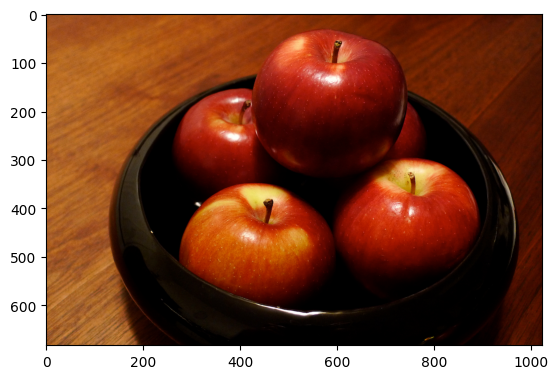

识别结果: apple


In [5]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

data_path = './datasets/Fruit/valid'

# 加载模型
model = torch.load('./weights/finetuned_pruned_resnet18.pt')
model.to(device)

# 类别标签
label_cls = [folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]

# 预处理数据
image = cv2.imread("./datasets/Fruit/valid/apple/Image_7.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

img = Image.fromarray(image)
img = transform(img).unsqueeze(0).to(device)  # (3) 添加批次维度  (4) 设备转移（数据）

# （5）模型推理
model.eval()
output = model(img)

# （6）后处理
predicted_index = torch.argmax(output, dim=1).cpu().item()  # 获取预测的类别索引

# （7）映射到类别标签  （8）输出结果
print(f"识别结果: {label_cls[predicted_index]}")

### 11.3 模型格式转换

训练好的模型通常都需要转化为中间件ONNX格式。ONNX（Open Neural Network Exchange）是一个开放的格式，它允许模型在不同的深度学习框架之间进行转换和使用。ONNX格式的模型可以被许多深度学习框架使用，包括TensorFlow、PyTorch、MXNet、Caffe、CNTK、CoreML、Keras、Scikit-learn等。

In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载模型
model = torch.load('./weights/finetuned_pruned_resnet18.pt')
model.to(device)

# 准备一个模型输入的示例
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# 指定ONNX文件的保存路径
onnx_file_name = "./weights/finetuned_pruned_resnet18.onnx"

# 导出模型
torch.onnx.export(model,                # 被量化的模型
                  dummy_input,                  # 模型输入的示例
                  onnx_file_name,               # ONNX文件的保存路径
                  export_params=True,           # 是否导出模型参数
                  opset_version=11,             # ONNX算子集的版本
                  do_constant_folding=True,    # 是否执行常量折叠优化
                  input_names=['input'],       # 输入模型的张量的名称
                  output_names=['output'],     # 输出模型的张量的名称
                  dynamic_axes={'input' : {0 : 'batch_size'},    # 可变长度的轴
                                'output' : {0 : 'batch_size'}})

### 11.4 模型量化

要对ONNX模型进行量化，可以使用ONNX Runtime提供的量化工具。ONNX Runtime提供了两种量化方式：静态量化和动态量化。

1.动态量化

动态量化是指在训练过程中，模型的权重和激活值不断更新，因此需要根据模型的实际运行情况对其进行量化。动态量化的过程包括两步：首先，模型的权重和激活值会被转换成定点数，然后，模型的计算会被量化。

现在我们来展示如何对onnx模型进行动态量化（Dynamic Quantization）：

In [7]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

# 输入模型路径
input_model_path = './weights/finetuned_pruned_resnet18.onnx'
# 输出量化后的模型路径
output_model_path = './weights/finetuned_pruned_resnet18_quantized.onnx'

# 动态量化
quantize_dynamic(
    input_model_path,  # 输入模型路径
    output_model_path,  # 输出量化后的模型路径
    weight_type=QuantType.QUInt8  # 权重量化类型，可以选择QUInt8或QInt8
)

print(f"量化后的模型已保存到: {output_model_path}")

量化后的模型已保存到: ./weights/finetuned_pruned_resnet18_quantized.onnx


2. 静态量化

静态量化是指在训练过程中，模型的权重和激活值不断更新，但只需要对模型的权重进行量化，而不对激活值进行量化。静态量化的过程包括两步：首先，模型的权重会被转换成定点数，然后，模型的计算会被量化。

In [8]:
import os
from PIL import Image
import numpy as np

# 图像文件夹路径
data_path = "./datasets/Fruit/train"

# 加载和预处理图像
def preprocess_image(image_path):
    image = Image.open(image_path).resize((224, 224))  # 调整大小
    image = np.array(image)  # 转换为 NumPy 数组

    # 如果图像是 4 通道（RGBA），转换为 3 通道（RGB）
    if image.shape[-1] == 4:
        image = image[..., :3]  # 取前 3 个通道

    image = image.transpose(2, 0, 1)  # [H, W, C] -> [C, H, W]
    image = image / 255.0  # 归一化到 [0, 1]
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)  # 均值
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)  # 标准差
    image = (image - mean) / std  # 标准化
    image = np.expand_dims(image, axis=0).astype(np.float32)  # 添加 batch 维度
    return image

# 加载校准数据
calibration_data = []
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path)[:10]:  # 每个类别取10张图像
            image_path = os.path.join(folder_path, file)
            image = preprocess_image(image_path)
            calibration_data.append(image)

print(f"加载了 {len(calibration_data)} 张校准图像")

加载了 100 张校准图像


In [9]:
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType

# 校准数据读取器
class CustomCalibrationDataReader(CalibrationDataReader):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.index = 0  # 添加索引以跟踪当前数据位置

    def get_next(self):
        if self.index < len(self.data):
            inputs = self.data[self.index]
            self.index += 1
            return {"input": inputs}  # 确保返回的键与模型输入名称匹配
        return None  # 没有数据时返回 None

# 创建校准数据读取器
calibration_data_reader = CustomCalibrationDataReader(calibration_data)

# 输入模型路径
input_model_path = './weights/finetuned_pruned_resnet18.onnx'
# 输出量化后的模型路径
output_model_path = './weights/fp_resnet18_quantized.onnx'

# 静态量化
quantize_static(
    input_model_path,  # 输入模型路径
    output_model_path,  # 输出量化后的模型路径
    calibration_data_reader,  # 校准数据读取器
    quant_format=QuantType.QInt8,  # 量化格式
    activation_type=QuantType.QUInt8  # 激活值量化类型
)

print(f"静态量化后的模型已保存到: {output_model_path}")

静态量化后的模型已保存到: ./weights/fp_resnet18_quantized.onnx


### 11.5 模型部署

对量化后的ONNX模型进行推理可以使用ONNX Runtime库。代码如下：

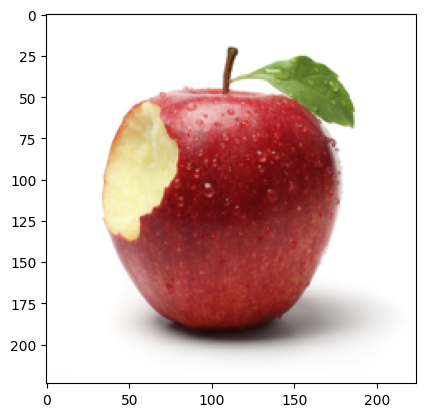

识别结果: apple


In [12]:
import onnxruntime as ort  # 导入ONNX Runtime库，用于加载和运行ONNX模型
import numpy as np
from PIL import Image  # 导入PIL库中的Image模块，用于加载和处理图像

data_path = './datasets/Fruit/valid'

# 加载并预处理图像
image_path = './datasets/Fruit/valid/apple/Image_10.jpg'  # 输入图像路径
image = Image.open(image_path).resize((224, 224))  # 打开图像并调整大小为224x224
plt.imshow(image)
plt.show()

image = np.array(image).transpose(2, 0, 1)  # 将图像从[H, W, C]转换为[C, H, W]格式
image = image / 255.0  # 将像素值归一化到[0, 1]范围
mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)  # 均值
std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)  # 标准差
image = (image - mean) / std
image = np.expand_dims(image, axis=0).astype(np.float32)  # 添加batch维度，变为[1, C, H, W]

# 类别标签
label_cls = [folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]
# # 类别标签排序
# label_cls = sorted([folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))])

# 加载量化后的ONNX模型
session = ort.InferenceSession('./weights/fp_resnet18_quantized.onnx')  # 创建ONNX Runtime推理会话
input_name = session.get_inputs()[0].name  # 获取模型的输入节点名称
output_name = session.get_outputs()[0].name  # 获取模型的输出节点名称

# 模型推理
outputs = session.run([output_name], {input_name: image})  # 模型推理，传入输入数据

# 输出推理结果
predicted_index = np.argmax(outputs[0], axis=1)[0]  # 获取输出结果中概率最大的类别索引
# 映射到类别标签, 并输出结果
print(f"识别结果: {label_cls[predicted_index]}")

2. C++推理

将模型转换为ONNX格式后，可以使用ONNX Runtime进行C++推理。ONNX Runtime是一个高性能的推理引擎，支持多种硬件平台，包括CPU和GPU。确保你已经安装了ONNX Runtime C++库,然后使用ONNX Runtime C++ API进行模型推理。

【C++代码示例待编写】

3. 模型SDK的制作

将训练完成的模型打包成SDK（软件开发工具包）是一个涉及多个步骤的过程，旨在使模型易于在不同应用程序中集成和使用。以下是将模型打包成SDK的一般步骤：

1. **模型优化和转换**：
   - 对模型进行必要的优化，如剪枝、量化、转换为低精度格式等，以提高模型的运行效率。
   - 如果模型是使用PyTorch、TensorFlow等框架训练的，将其转换为一种更适合部署的格式，如ONNX、TorchScript、TensorFlow Lite等。

2. **选择推理引擎**：
   - 根据目标平台选择合适的推理引擎，如ONNX Runtime、TensorRT、Core ML、TensorFlow Lite等。

3. **编写推理代码**：
   - 使用选定的推理引擎，编写加载模型、处理输入输出数据、执行模型推理的C++代码。

4. **封装API**：
   - 将推理代码封装成一套API，提供简洁的接口供外部调用。这些API可以是函数、类或库。

5. **创建示例和文档**：
   - 提供使用SDK的示例代码，展示如何加载模型、进行推理等。
   - 编写详细的开发文档，包括API说明、使用指南、故障排除等。

6. **编译和构建**：
   - 将代码编译成库文件（如`.dll`、`.so`、`.dylib`等），并确保所有依赖项都已正确链接。
   - 创建安装包或分发包，包含库文件、头文件、许可证文件和示例代码。

7. **测试**：
   - 在目标平台上对SDK进行彻底的测试，确保其稳定性和性能符合预期。

8. **打包和分发**：
   - 将编译后的库、头文件、示例代码、文档等打包，可以通过压缩文件、安装程序或其他分发方法提供给用户。

9. **版本控制和更新**：
   - 为SDK设置版本号，便于管理和更新。
   - 根据用户反馈和新的需求，定期更新SDK。

10. **许可和版权**：
    - 确保所有使用的第三方库和代码都符合相应的许可协议。
    - 在SDK中包含必要的版权和许可信息。

11. **支持和维护**：
    - 提供技术支持和维护服务，帮助用户解决使用SDK时遇到的问题。

在实际操作中，你可能还需要考虑以下因素：

- **平台兼容性**：确保SDK能够在不同的操作系统和硬件平台上运行。
- **安全性**：确保SDK的安全性，特别是如果它将被用于生产环境。
- **国际化**：如果SDK将被全球用户使用，考虑支持多语言。
- **定制化**：根据目标用户群体的需求，提供定制化的SDK版本。

打包SDK是一个涉及多个领域的综合任务，需要软件工程、系统架构、项目管理和用户体验设计等多方面的知识。